In [52]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, GroverOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal

In [40]:
def create_edge_matrix(number_of_points, probability):
    edge_matrix = np.ones((number_of_points,number_of_points))
    for i in range(0,number_of_points):
        for j in range(i,number_of_points):
            if random.random()>probability or i==j:
                edge_matrix[i,j]=0
                edge_matrix[j,i]=0
    return edge_matrix

create_edge_matrix(5, 0.5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [41]:
def Create_quadratic_program(n, edge_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i))
        linear_coefficients.append(1)
    for i in range(n):
        for j in range(i,n):
            if edge_matrix[i,j] == 1 and i!=j:
                summation_terms[('x'+str(i),'x'+str(j))] = summation_terms.get(('x'+str(i),'x'+str(j)), -4*n)
    qubo.maximize(linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    op, offset = qubo.to_ising()
    return op, offset, qubo
Create_quadratic_program(5, create_edge_matrix(5,0.5))

(SummedOp([PauliOp(Pauli(z=[True, False, False, False, False], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[False, True, False, False, False], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[False, False, True, False, False], x=[False, False, False, False, False]), coeff=-4.5), PauliOp(Pauli(z=[False, False, False, True, False], x=[False, False, False, False, False]), coeff=-9.5), PauliOp(Pauli(z=[False, False, False, False, True], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[True, True, False, False, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[True, False, True, False, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[False, True, False, True, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[True, False, False, False, True], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[False, True, False, False, True]

In [42]:
def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
op, offset, qubo = Create_quadratic_program(16, create_edge_matrix(16,0.5))
result_exact(qubo)

############ working fine till 16 only ##############

5.0

In [43]:
def get_cost_and_time_numpy(n1, n2):
    cost_vs_n_fromnumpy = list()
    time_vs_n_fromnumpy = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(16, create_edge_matrix(16,0.5))
            cost.append(result_exact(qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromnumpy.append((x, y))
        time_vs_n_fromnumpy.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromnumpy, time_vs_n_fromnumpy

In [44]:
def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
result_qaoa(qubo)

2.0

In [45]:
def get_cost_and_time_QAOA(n1, n2):
    cost_vs_n_fromQAOA = list()
    time_vs_n_fromQAOA = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
            cost.append(result_qaoa(qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromQAOA.append((x, y))
        time_vs_n_fromQAOA.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromQAOA, time_vs_n_fromQAOA

In [46]:
def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    return binary[::-1]
dec_to_bin(5,4)

array([0., 1., 0., 1.])

In [47]:
def brut_force(n, edge_matrix):
    best_cost = 0
    best_case =None
    flag = True
    for i in range(n):
        for j in range(i,n):
            if edge_matrix[i,j] == 1 and i!=j:
    for i in range(2**n):
        binary = dec_to_bin(i,n)
        for j in range(n-1):
            for k in range(j+1,n):
                    flag =False
        if flag == True:
            best_cost = sum(binary)
            best_case = binary
    return best_cost, best_case
brut_force(5, create_edge_matrix(5,0.5))

IndentationError: expected an indented block (<ipython-input-47-8952427bdd37>, line 9)

In [48]:
def using_vqe(qubitop,qubo):
    seed = 10598
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    spsa = SPSA(maxiter=300)
    ry = TwoLocal(qubitop.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
    vqe = VQE(qubitop, ry, spsa, quantum_instance=quantum_instance)
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
using_vqe(op, qubo)

2.0

In [49]:
def get_cost_and_time_VQE(n1, n2):
    cost_vs_n_fromVQE = list()
    time_vs_n_fromVQE = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
            cost.append(using_vqe(op, qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromVQE.append((x, y))
        time_vs_n_fromVQE.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromVQE, time_vs_n_fromVQE

In [59]:
def using_grover(n,qubo):
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance= backend)
    results = grover_optimizer.solve(qubo)
    return results
op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
using_grover(5,qubo)

No classical registers in circuit "circuit19992", counts will be empty.


StopIteration: 

In [50]:
print("Cost and time using NumpyEigenSolver")
cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver = get_cost_and_time_numpy(4, 10)

print("")

print("Cost and time using VQE")
cost_vs_n_fromVQE, time_vs_n_fromVQE = get_cost_and_time_VQE(4, 10)

print("")

print("Cost and time using QAOA")
cost_vs_n_fromQAOA, time_vs_n_fromQAOA = get_cost_and_time_QAOA(4, 10)

Cost and time using NumpyEigenSolver
n= 4 cost= 4.6 time= 0.46355643272399905
n= 5 cost= 5.4 time= 0.3907613277435303
n= 6 cost= 4.4 time= 0.42804827690124514
n= 7 cost= 4.6 time= 0.42984986305236816
n= 8 cost= 4.8 time= 0.42147212028503417
n= 9 cost= 5.2 time= 0.4027284622192383

Cost and time using VQE
n= 4 cost= 2.8 time= 3.4994446277618407
n= 5 cost= 2.8 time= 3.613767719268799
n= 6 cost= 2.8 time= 3.5293391227722166
n= 7 cost= 2.8 time= 3.380984306335449
n= 8 cost= 2.4 time= 3.1509222030639648
n= 9 cost= 2.6 time= 3.2838172912597656

Cost and time using QAOA
n= 4 cost= 2.4 time= 0.20120882987976074
n= 5 cost= 2.8 time= 0.14340953826904296
n= 6 cost= 2.2 time= 0.14979920387268067
n= 7 cost= 2.6 time= 0.15019822120666504
n= 8 cost= 2.8 time= 0.14576997756958007
n= 9 cost= 2.8 time= 0.13334856033325196


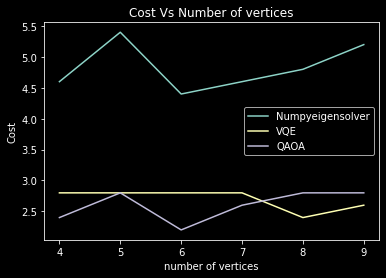

In [53]:
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
x, y = zip(*cost_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*cost_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*cost_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()


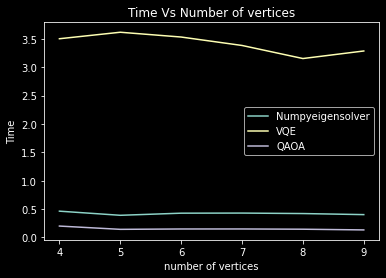

In [54]:
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
x, y = zip(*time_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*time_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*time_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()